<a href="https://colab.research.google.com/github/alro923/Tensorflow_Study/blob/main/More_on_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__) # tensorflow 2.x

2.3.0


In [ ]:
def plot_series(time, series, format="-", start=0, end=None):
  plt.plot(time[start:end], series[start:end], format)
  plt.xlabel("Time")
  plt.ylabel("Value")
  plt.grid(True)

def trend(time, slope =0):
  return slope * time

def seasonal_pattern(season_time):
  """Just an arbitary pattern, you can change it if you wish"""
  return np.where(season_time < 0.4,
                  np.cos(season_time * 2 * np.pi),
                  1/np.exp(3*season_time) )

def seasonality(time, period, amplitude=1, phase=0):
  """Repeats the same pattern at each period"""
  season_time = ((time + phase) % period) / period
  return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level = 1, seed=None):
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time))*noise_level

In [ ]:
time = np.arange(4*365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period = 365, amplitude = amplitude)

# Update with noise
series += noise(time, noise_level, seed=42)

In [ ]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift = 1, drop_remainder = True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size +1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset


In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

# LSTM
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x : tf.expand_dims(x, axis = -1), input_shape = [None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x*100.0)             
])

In [ ]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10 ** (epoch/20))
optimizer = tf.keras.optimizers.SGD(lr = 1e-8, momentum = 0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics = ["mae"])
history = model.fit(train_set, epochs=100, callbacks = [lr_schedule])

Epoch 1/100
8/8 [==============================] - 0s 32ms/step - loss: 21.6170 - mae: 22.1120
Epoch 2/100
8/8 [==============================] - 0s 27ms/step - loss: 21.5606 - mae: 22.0553
Epoch 3/100
8/8 [==============================] - 0s 33ms/step - loss: 21.4693 - mae: 21.9635
Epoch 4/100
8/8 [==============================] - 0s 30ms/step - loss: 21.3590 - mae: 21.8526
Epoch 5/100
8/8 [==============================] - 0s 32ms/step - loss: 21.2319 - mae: 21.7241
Epoch 6/100
8/8 [==============================] - 0s 35ms/step - loss: 21.0881 - mae: 21.5810
Epoch 7/100
8/8 [==============================] - 0s 33ms/step - loss: 20.9298 - mae: 21.4234
Epoch 8/100
8/8 [==============================] - 0s 33ms/step - loss: 20.7610 - mae: 21.2542
Epoch 9/100
8/8 [==============================] - 0s 31ms/step - loss: 20.5696 - mae: 21.0635
Epoch 10/100
8/8 [==============================] - 0s 33ms/step - loss: 20.3591 - mae: 20.8510
Epoch 11/100
8/8 [==============================]

(1e-08, 0.0001, 0.0, 30.0)

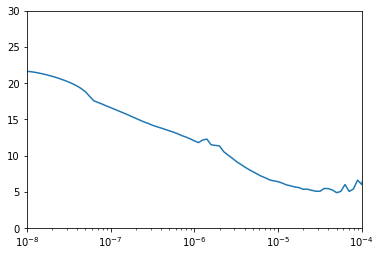

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

dataset = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x : tf.expand_dims(x, axis = -1), input_shape = [None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x*100.0)             
])

model.compile(loss="mae", optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum = 0.9))
history = model.fit(dataset, epochs =500, verbose = 0)

tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),

In [ ]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time - window_size:]
results = np.array(forecast)[:, 0, 0]

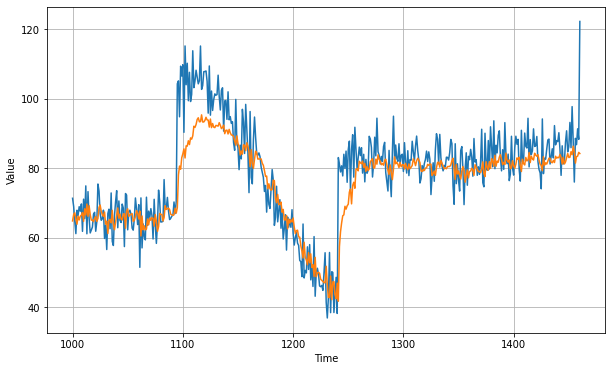

In [ ]:
plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.8643975